In [1]:
import sys
sys.path.append('../scripts/')
from robot import * 
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self,init_pose):
        self.pose = init_pose
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        # 式(5.12)処理
        noised_nu = nu + ns[0] * math.sqrt(abs(nu) / time) + ns[1] * math.sqrt(abs(omega) / time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu) / time) + ns[3] * math.sqrt(abs(omega) / time)
        self.pose = IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose) # 粒子の移動
        

In [3]:
# 現在地と粒子の数

class Mcl:
    # motion_nosise_stds:標準偏差σ_ab
    def __init__(self,init_pose,num,motion_noise_stds):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2 ]) # 与えられた要素を二乗して対角行列へ返す
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)
        
    def motion_update(self,nu,omega,time):
        #print(self.motion_noise_rate_pdf.cov)
        # class Particle のmotion_updateを全粒子に行う
        for p in self.particles: p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
    
    # 粒子を描画する(位置、姿勢)
    def draw(self,ax,elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles] # ベクトルのx成分
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color = "blue" , alpha = 0.5)) # 粒子の位置と姿勢を登録

In [4]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self,observation = None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)# class Mclのmotion_update
        self.prev_nu,self.prev_omega = self.nu,self.omega
        return self.nu,self.omega

    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
        elems.append(ax.text(0,0,"hoge",fontsize = 10))

In [5]:
initial_pose = np.array([0,0,0]).T
estimator = Mcl(initial_pose,100,motion_noise_stds = {"nn":0.01,"no":0.02,"on":0.03,"oo":0.04})
a = EstimationAgent(0.1,0.2,10.0 / 180 * math.pi,0.1)
estimator.motion_update(0.2,10.0 / 180 * math.pi,0.1)
for p in estimator.particles:
    print(p.pose)


[0.02069471 0.00013891 0.01342486]
[0.02554415 0.00012258 0.0095973 ]
[0.01479559 0.00018151 0.0245343 ]
[0.02123796 0.00012524 0.0117941 ]
[0.01987213 0.00015699 0.01580005]
[0.02368    0.00015077 0.01273397]
[0.01527823 0.00012461 0.01631189]
[0.02096076 0.0001646  0.01570527]
[0.02241478 0.00016856 0.01504005]
[0.01683361 0.00013587 0.01614242]
[0.0173997  0.00025529 0.02934261]
[0.01992215 0.00018137 0.01820762]
[0.0174425  0.0002011  0.02305745]
[0.02090031 0.00020778 0.01988272]
[0.01885441 0.00017954 0.01904467]
[0.02720562 0.00019297 0.0141856 ]
[0.02250653 0.00012265 0.01089925]
[0.02337401 0.00019825 0.01696323]
[0.01295273 0.00018348 0.02832858]
[0.02629436 0.00012442 0.00946393]
[0.0153438  0.00014579 0.01900306]
[0.01700337 0.00011324 0.01331938]
[0.02196968 0.00028685 0.02611211]
[0.02080563 0.00023357 0.02245157]
[0.02093966 0.00010336 0.00987239]
[0.01732315 0.00012378 0.01429084]
[0.02056091 0.00023834 0.02318278]
[0.01845727 0.00024241 0.02626516]
[0.01928339 0.000121

<IPython.core.display.Javascript object>


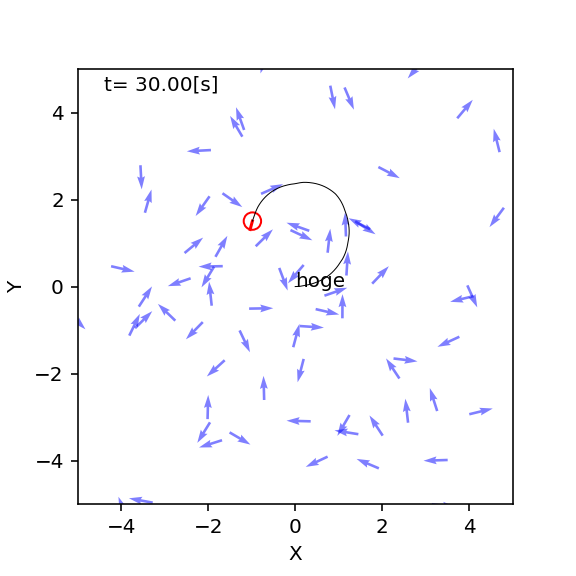

In [7]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30,time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100,motion_noise_stds)
    circling = EstimationAgent(time_interval,0.2,10.0 / 180 * math.pi,estimator)
    r = Robot(initial_pose,sensor = None,agent = circling,color = "red")
    world.append(r)
    
    world.draw()
    
trial({"nn":1,"no":2,"on":3,"oo":4})
# noiseのパラメタがテキトーなので、robotと粒子が乖離してしまう